In [1]:
from lib import *

# Problem to solve: Poisson equation

$$ \frac{\partial ^2 \phi}{\partial x^2} + \frac{\partial ^2 \phi}{\partial y^2} = f(x,y) $$

where 
$$f(x,y) = x^2 + y^2 + 1$$

with periodic boundary conditions:
* $\phi(x,5) = \phi(x, -5)$
* $\phi(5,y) = \phi(-5,y)$



In [2]:
def f(x, y):
    return x*x/(1000) + (y*y)/1000 + x*y / 100 + 1

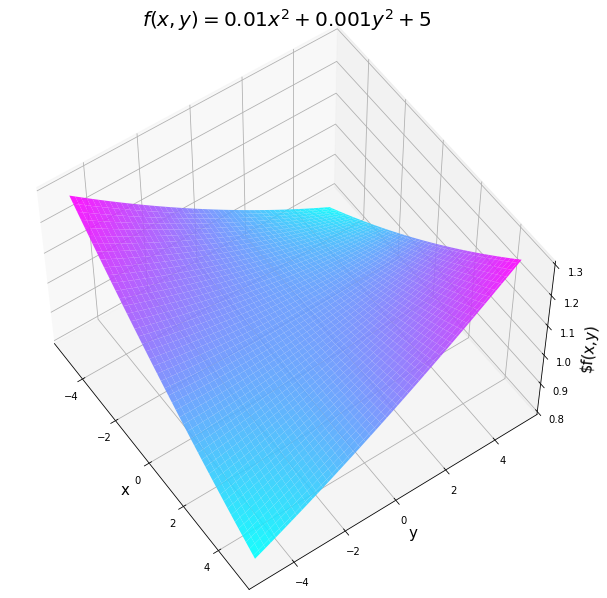

In [3]:
n = 100
xx = np.linspace(-5, 5, n)
yy = np.linspace(-5, 5, n)
x,y = np.meshgrid(xx,yy)

source = f(x,y) 

plot_3D(x, y,source, x_label = 'x', y_label = 'y', z_label = '$f(x,y)', title = '$f(x,y) = 0.01 x^2 + 0.001 y^2 + 5$', elev=55., azim=-35)

In [4]:
n = 100

xx = np.linspace(-5, 5, n)
yy = np.linspace(-5, 5, n)
x,y = np.meshgrid(xx,yy)

xp_ = np.linspace(-5, 5, n)
yq_ = np.linspace(-5, 5, n)
xp,yq = np.meshgrid(xp_,yq_)

h = xp_[1] - xp_[0]

f_pq = f(xp,yq) 


# 3. Matrix form: Ax = b


$$ \frac{\partial ^2 \phi}{\partial x^2} + \frac{\partial ^2 \phi}{\partial y^2} = f(x,y) $$

where 
$$f(x,y) = \cos (3x + 4y) - \cos(5x - 2y)$$

with periodic boundary conditions:
* $\phi(x,0) = \phi(x, 2\pi)$
* $\phi(0,y) = \phi(2\pi, y)$


The lowest order $\mathcal{O}(h^2)$ disretization has the form:

$$ \frac{\phi_{p+1, q} - 2\phi_{p,q} + \phi_{p-1, q}}{h^2} + 
    \frac{\phi_{p, q+1} - 2\phi_{p,q} + \phi_{p, q-1}}{h^2} = f_{p,q}$$
    
$$ \frac{\phi_{p+1, q} + \phi_{p-1, q} + \phi_{p, q+1} + \phi_{p, q-1}  - 4\phi_{p,q}}{h^2} = f_{p,q}$$

We want to write the above equation in a matrix form: $D \vec{\phi} = f$ where
matrix $D$ correspons to coefficients, vector $\vec{\phi}$ corresponds to discretized coordinates $[\phi_{pq}]$ and $f_{pq}$ are know values of f evaluated at discrete points $f_{pq} = f(x_p, y_q)$

We have $n \cdot n = n^2$ unknow $\phi _{pq}$. First of all, we need to vectorize $\phi_{pq}$ and $f_{pq}$. In order to do that, we introduce a multiindex:

$$0\leq I_{i,j} = iN+j<N^2$$

$$\phi_{I-N}+\phi_{I+N}+\phi_{I-1}+\phi_{I+1}-4\phi_{I}= A_{IJ}x_J = h^2 \cdot f_{I}$$

$$A_{IJ} = \delta_{I-N, J}+\delta_{I+N, J}+\delta_{I-1, J}+\delta_{I+1, J}-4\delta_{I,J}$$

Boundary conditions:
$$\phi_{[0:N]}=\phi_{bottom}\qquad \phi_{[0:N(N-1):N]}=\phi_{left}$$

$$\phi_{[N(N-1):N^2]}=\phi_{top}\qquad \phi_{[(N-1):N^2:N]}=\phi_{right}$$

In [5]:
n = 100
xx = np.linspace(-5, 5, n)
yy = np.linspace(-5, 5, n)

dx = xx[1] - xx[0]
dy = yy[1] - yy[0]

x,y= np.meshgrid(xx,yy)

f_matrix = f(x,y)
f_vector = f_matrix.flatten()

N = len(f_vector)

D = np.diagflat( np.ones(N) * (-4))

for i in range(1,N-1):
    D[i][i] = -4
    D[i][i+1] = 1
    D[i][i-1] = 1
    D[i][(i+n)%N] = 1
    D[i][(i-n)%N] = 1

## Periodic boundary conditions:
D[N-1][N-2] = 1
D[N-1][n-1] = 1
D[N-1][N-n-1] = 1

D[0][1]= 1
D[0][N-n]=1
D[0][n]=1

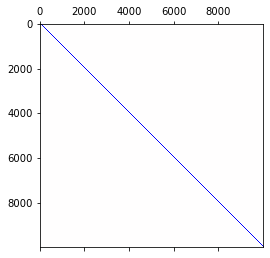

In [6]:
plt.matshow(D, cmap='bwr', vmin=-4, vmax=4)

In [7]:
import scipy.sparse as sp  # provides sparse matrices
import scipy.sparse.linalg as sl

In [8]:
Φ1_vector = np.linalg.solve(D, f_vector) 

In [9]:
Φ2_vector = sl.spsolve(D, f_vector)

/home/neofelia/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [10]:
Φ1_matrix = cp.copy(Φ1_vector).reshape((n, n))
Φ2_matrix = cp.copy(Φ2_vector).reshape((n, n))

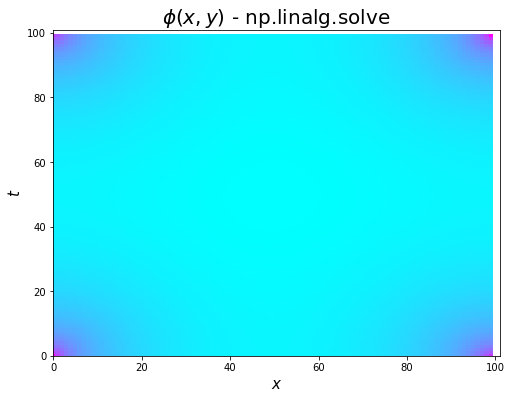

In [11]:
plot_2D(Φ1_matrix, n,n, title = '$\phi(x,y)$ - np.linalg.solve')

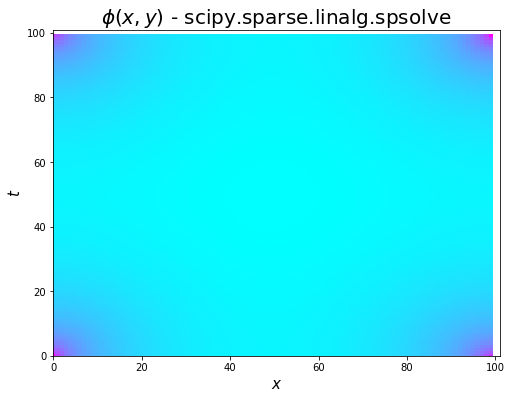

In [12]:
plot_2D(Φ2_matrix, n,n, title = '$\phi(x,y)$ - scipy.sparse.linalg.spsolve')

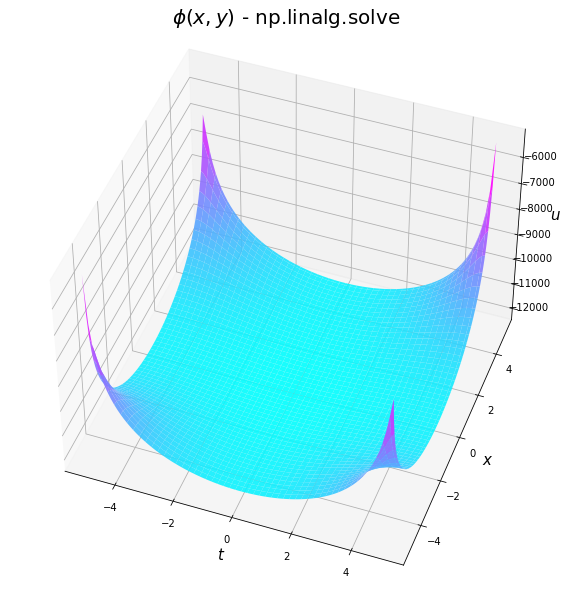

In [13]:
plot_3D(xp, yq, Φ1_matrix, title =  '$\phi(x,y)$ - np.linalg.solve', elev=45., azim=-70)

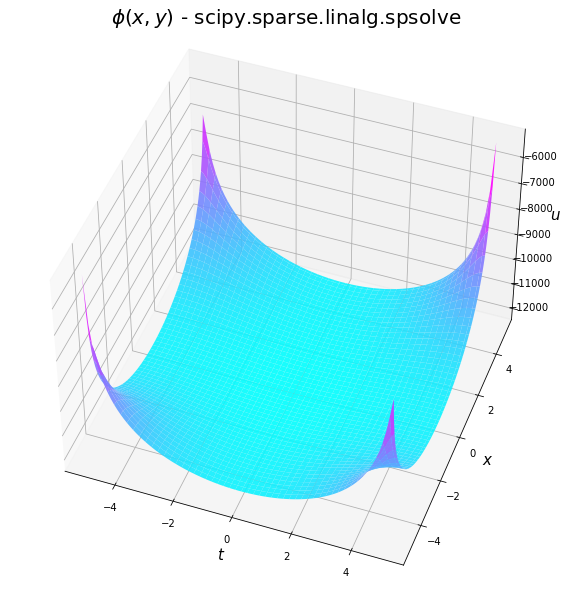

In [14]:
plot_3D(xp, yq, Φ2_matrix, title =  '$\phi(x,y)$ - scipy.sparse.linalg.spsolve', elev=45., azim=-70)

In [15]:
STOP

NameError: name 'STOP' is not defined

#### LU decomposition:

We rewrite matrix $A$ as $A=LU$, where where $L$ and $U$ are lower and upper triangular matrices.
Then:

$$Ax=b\;\Rightarrow\;LUx=b\;\Rightarrow\;\begin{cases}
Ly&=b\\
Ux&=y
\end{cases}$$

Forward substitution:

$$\begin{bmatrix}l_{11}&0&0\\l_{21}&l_{22}&0\\l_{31}&l_{32}&l_{33}\end{bmatrix}
\begin{bmatrix}y_1\\y_2\\y_3\end{bmatrix}=
\begin{bmatrix}b_1\\b_2\\b_3\end{bmatrix} $$


$$y_1=\frac{b_1}{l_{11}},\qquad y_2=\frac{b_2-l_{21}y_1}{l_{22}},\qquad y_3=\frac{b_3-l_{31}y_2-l_{32}y_2}{l_{33}}$$


Backward substitution:

$$\begin{bmatrix}u_{11}&u_{12}&u_{13}\\0&u_{22}&u_{23}\\0&0&u_{33}\end{bmatrix}
\begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix}=
\begin{bmatrix}y_1\\y_2\\y_3\end{bmatrix}$$

$$x_3=\frac{y_3}{u_{33}},\qquad x_2=\frac{y_2-u_{23}x_3}{u_{22}},\qquad x_1=\frac{y_1-u_{12}x_2-u_{13}x_3}{u_{11}}$$

#### dollittle method:

1. For given matrix $ A = (n \times n)$ we prepare two matrices $L, U= (n \times n)$
2. We set the diagonal of $L$ to 1
3. We find $U_{ij}$ and $L_{ij}$ from:
$$ u_{ij}=a_{ij}-\sum _{k=1}^{i-1}l_{ik}u_{kj}\qquad i\leq j\leq n $$
$$ l_{ji}={\frac {1}{u_{ii}}}\left(a_{ji}-\sum _{k=1}^{i-1}l_{jk}u_{ki}\right) \qquad i< j\leq n $$

4. (Theoretically) A = LU


In [ ]:
def LU_Doolittle(A):

    A = A.astype(np.float64)
    n= A.shape[0]
    L = np.zeros_like(A).astype(np.float64)
    U = np.zeros_like(A).astype(np.float64)
    np.fill_diagonal(L,1)
    
    print("A.shape = {:}\t rank(A) = {:}\t\t det(A) {:}".format(A.shape, np.linalg.matrix_rank(A),  np.linalg.det(A)))
    
    for i in range(n):
        for j in range(i, n):
            U[i,j] = A[i,j] - np.sum(L[i,:i]*U[:i, j])
            #U[i][j] = A[i][j] - sum( L[i][k]*U[k][j] for k in range(i))
              
        for j in range(i+1,n):
            #print("i = ", i,"j = ", j, "\t", U[0][0], U[1][1], U[2][2], U[3][3], 1.0 /U[i][i], "\n")

            ##both methods give the same results:
            #L[j][i] = (A[j][i]- sum( L[j][k]*U[k][i] for k in range(i))) / U[i][i]
            L[j,i] = 1.0/U[i][i] * (A[j,i] - np.sum(L[j,:i]*U[:i, i]))
    
    return L, U

In [ ]:
A = np.array([[1,0,3,4], [0,1,0,1], [0,1,5,0], [0,17,13,0]])

L, U = LU_Doolittle(A)


B = np.matmul(L,U) 
print("\n",A)
print("\n", B.round(5))
(A-B).round(5)